In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']

In [4]:
#Read previously saved data
data = pd.read_csv('/content/drive/MyDrive/fitness/output_keypoints_data.csv')
data.head()

,action_name,standard_type,frame_index,sequence,Nose_x,Right Eye_x,Left Eye_x,Right Ear_x,Left Ear_x,Right Shoulder_x,...,Right Elbow_y,Left Elbow_y,Right Wrist_y,Left Wrist_y,Right Hip_y,Left Hip_y,Right Knee_y,Left Knee_y,Right Ankle_y,Left Ankle_y
0,Dumbbell Flat Bench Press,nonstandard01,0,0,0.525609,0.598599,0.485133,0.680254,0.411173,0.791400,...,0.742262,0.772125,0.871600,0.911305,0.501701,0.508579,0.261648,0.255344,0.036935,0.0
1,Dumbbell Flat Bench Press,nonstandard01,2,0,0.526668,0.600831,0.486696,0.682708,0.412949,0.791740,...,0.745493,0.774178,0.876326,0.920597,0.502436,0.508988,0.261405,0.255176,0.036693,0.0
2,Dumbbell Flat Bench Press,nonstandard01,4,0,0.520556,0.595551,0.482698,0.679659,0.414519,0.789199,...,0.747884,0.782035,0.876426,0.924035,0.501267,0.509208,0.259804,0.255130,0.035944,0.0
3,Dumbbell Flat Bench Press,nonstandard01,15,1,0.531032,0.598307,0.498048,0.679572,0.440884,0.801587,...,0.777767,0.836893,0.918034,0.958946,0.513360,0.520393,0.274010,0.251076,0.069510,0.0
4,Dumbbell Flat Bench Press,nonstandard01,17,1,0.531414,0.604256,0.498173,0.681931,0.431039,0.797941,...,0.780296,0.811265,0.920151,0.949701,0.498074,0.506769,0.260159,0.255756,0.035692,0.0


In [5]:
# Define 12 key points to keep
keypoints_to_keep = [
    'Right Shoulder', 'Left Shoulder', 'Right Elbow', 'Left Elbow',
    'Right Wrist', 'Left Wrist', 'Right Hip', 'Left Hip',
    'Right Knee', 'Left Knee', 'Right Ankle', 'Left Ankle'
]

In [6]:
# Constructs the column name to process
keypoint_columns = []
for kp in keypoints_to_keep:
    keypoint_columns.append(f'{kp}_x')
    keypoint_columns.append(f'{kp}_y')

# Data cleaning and mean filling
data[keypoint_columns] = data.groupby(['action_name', 'standard_type'])[keypoint_columns].transform(
    lambda group: group.fillna(group.mean())
)

# Separate data for standard and non-standard actions
standard_data = data[data['standard_type'] == 'standard']
nonstandard_data = data[data['standard_type'] != 'standard']

# Ensure that the action_name of the non-standard action exists in the standard action
standard_action_names = standard_data['action_name'].unique()
nonstandard_data = nonstandard_data[nonstandard_data['action_name'].isin(standard_action_names)]

# Prepare three frame combination features for standard action data
grouped_data_standard = []
group_size = 3  # Every three frames is a group

In [7]:
for name, group in standard_data.groupby(['action_name', 'sequence']):## Group standard action data according to action_name and sequence.
    if len(group) >= group_size:
        for i in range(0, len(group) - group_size + 1, 1): ## For example, if there are 5 frames in the group, frames 0-2, 1-3, and 2-4 will be selected during iteration.
            frames = group.iloc[i:i + group_size]

            second_frame = frames.iloc[1][keypoint_columns].values ## Extract the second frame in the middle of the three frames to obtain the coordinate information of its key points.
            first_diff = frames.iloc[0][keypoint_columns].values - frames.iloc[1][keypoint_columns].values ## Calculate the difference between the first frame and the second frame, reflecting the change in displacement from the first frame to the second frame.
            third_diff = frames.iloc[2][keypoint_columns].values - frames.iloc[1][keypoint_columns].values

            combined_features = np.hstack([second_frame, first_diff, third_diff])

            grouped_data_standard.append({
                'action_name': name[0],
                'sequence': name[1],
                'features': combined_features,
                'second_frame_keypoints': second_frame
            })

# Converted to DataFrame: contains the action name, phase, combined features and other information, which is the result of extracting standard action features.
grouped_df_standard = pd.DataFrame(grouped_data_standard)

In [8]:
# Thermally code action_name to include all categories
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
onehot_encoder.fit(grouped_df_standard[['action_name']])

# Save OneHotEncoder
joblib.dump(onehot_encoder, 'action_onehot_encoder.pkl')

# Combine the class features encoded by unique heat with other numerical features
X_standard = np.hstack((onehot_encoder.transform(grouped_df_standard[['action_name']]),
                        np.vstack(grouped_df_standard['features'].values)))

# Get tag sequence
y_sequence_standard = grouped_df_standard['sequence']  # Action stage classification tags

# Feature standardization
scaler = StandardScaler()
X_standard_scaled = scaler.fit_transform(X_standard)
print(X_standard.shape)
print(X_standard)
print(X_standard_scaled)
print(y_sequence_standard)
# Save the standardization
joblib.dump(scaler, 'feature_scaler.pkl')


(90, 87)
[[1.0 0.0 0.0 ... 0.015963988999999998 -0.246511977 0.0]
 [1.0 0.0 0.0 ... -0.007015552999999999 -0.006754394999999996 0.0]
 [1.0 0.0 0.0 ... -0.005617988000000001 -0.12451191 0.0]
 ...
 [0.0 0.0 0.0 ... -0.0010558780000000031 0.0008785789999999905 0.0]
 [0.0 0.0 0.0 ... -0.01360656 -0.0007005469999999958 0.0]
 [0.0 0.0 0.0 ... 0.0002764550000000001 0.005175387000000087 0.0]]
[[ 3.74165739 -0.26726124 -0.26726124 ...  2.7958197  -7.28638342
   0.13148186]
 [ 3.74165739 -0.26726124 -0.26726124 ... -1.31550579 -0.0501813
   0.13148186]
 [ 3.74165739 -0.26726124 -0.26726124 ... -1.06546405 -3.60425943
   0.13148186]
 ...
 [-0.26726124 -0.26726124 -0.26726124 ... -0.24924591  0.18019199
   0.13148186]
 [-0.26726124 -0.26726124 -0.26726124 ... -2.49471881  0.13253187
   0.13148186]
 [-0.26726124 -0.26726124 -0.26726124 ... -0.01087499  0.30987536
   0.13148186]]
0     0
1     1
2     2
3     3
4     4
     ..
85    1
86    2
87    3
88    4
89    5
Name: sequence, Length: 90, dtype

['feature_scaler.pkl']

In [12]:
# Train the model on standard action data
rf_model_sequence = RandomForestClassifier(n_estimators=1000, random_state=42)

# The training set and validation set are randomly divided
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_standard_scaled, y_sequence_standard, test_size=0.4, random_state=42)

# Training the model
rf_model_sequence.fit(X_standard_scaled, y_sequence_standard)

# Evaluation model
y_pred = rf_model_sequence.predict(X_test)



#rf_model_sequence.fit(X_standard_scaled, y_sequence_standard)

# Make predictions on standard action data
#y_pred_standard = rf_model_sequence.predict(X_standard_scaled)

Accuracy of classification of standard action stages: 0.94
Standard action stage classification report：
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      1.00      1.00         5
           2       1.00      0.83      0.91         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         8
           5       1.00      0.80      0.89         5

    accuracy                           0.94        36
   macro avg       0.96      0.94      0.94        36
weighted avg       0.96      0.94      0.95        36



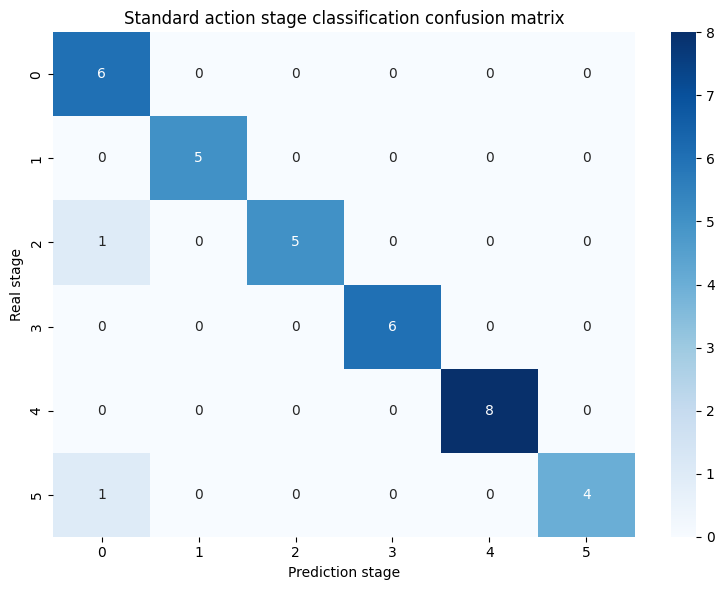

In [13]:
# Evaluation model
accuracy_standard = accuracy_score(y_test, y_pred)
print(f"Accuracy of classification of standard action stages: {accuracy_standard:.2f}")

# Print classification report
print("Standard action stage classification report：")
print(classification_report(y_test, y_pred))

# Draw the confusion matrix
conf_matrix_standard = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_standard, annot=True, fmt="d", cmap="Blues")
plt.title("Standard action stage classification confusion matrix")
plt.xlabel("Prediction stage")
plt.ylabel("Real stage")
plt.tight_layout()
plt.show()


In [11]:
# save the action phase classification model
joblib.dump(rf_model_sequence, 'action_stage_model.pkl')
files.download('action_stage_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Calculate and save key point averages for standard actions
grouped_data_standard_mean = []
for name, group in standard_data.groupby(['action_name', 'sequence']):
    keypoints_mean = group[keypoint_columns].mean().values
    grouped_data_standard_mean.append({
        'action_name': name[0],
        'sequence': name[1],
        'second_frame_keypoints': keypoints_mean
    })

standard_keypoints_mean = pd.DataFrame(grouped_data_standard_mean)

print(keypoints_mean.shape)
print(keypoints_mean)
print(standard_keypoints_mean.shape)
print(standard_keypoints_mean)

# Save the keypoint average of the standard action
standard_keypoints_mean.to_pickle('standard_keypoints_mean.pkl')

(24,)
[0.52936995 0.44144428 0.84570421 0.43157989 0.52461599 0.5864742
 0.95421348 0.57863911 0.50723459 0.69302702 1.         0.67925545
 0.57418112 0.21713536 0.80919617 0.2100444  0.55405728 0.15890479
 0.92749087 0.14926546 0.51406317 0.01013163 0.92741554 0.        ]
(90, 3)
               action_name  sequence  \
0      Barbell Bench Press         0   
1      Barbell Bench Press         1   
2      Barbell Bench Press         2   
3      Barbell Bench Press         3   
4      Barbell Bench Press         4   
..                     ...       ...   
85  Wide-Grip Lat Pulldown         1   
86  Wide-Grip Lat Pulldown         2   
87  Wide-Grip Lat Pulldown         3   
88  Wide-Grip Lat Pulldown         4   
89  Wide-Grip Lat Pulldown         5   

                               second_frame_keypoints  
0   [0.7798730286666666, 0.6802304853333333, 0.452...  
1   [0.7874629726666668, 0.7167803733333334, 0.345...  
2   [0.7839943726666667, 0.6746294536666667, 0.323...  
3   [0.742185